### Increasing number of filters to 64

In [1]:
import numpy as np
import keras
from keras.models import Sequential
from matplotlib import pyplot as plt
from keras.layers import Dense,Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization 
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, classification_report

Using TensorFlow backend.


In [4]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.loss = []
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))
        self.loss.append(logs.get('loss'))
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        y_predict = np.asarray(model.predict(X_val))
        y_val = np.argmax(y_val, axis=1)
        y_predict = np.argmax(y_predict, axis=1)
        self.val_recalls.append(recall_score(y_val, y_predict, average=None))
        self.val_precisions.append(precision_score(y_val, y_predict, average=None))
        self.val_f1s.append(f1_score(y_val,y_predict, average=None))

In [5]:
data = np.load('/home/aj/assignments/assign2/outfile.npz')
X_train=data["X_train.npy"]
X_test=data["X_test.npy"]
y_train=data["y_train.npy"]
y_test=data["y_test.npy"]
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0],28, 28,3).astype('float32')
X_test = X_test.reshape(X_test.shape[0],28, 28,3).astype('float32')
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

num_classes = y_test.shape[1]

input_shape=(28,28,3)
history = AccuracyHistory()

In [7]:
def create_model(filters,filt1_size,conv_stride,pool_size,pool_stride,opt,loss):
    model=Sequential()
    model.add(Conv2D(filters, kernel_size=(filt1_size, filt1_size), strides=(conv_stride, conv_stride),activation='relu',input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size), strides=(pool_stride,pool_stride), padding='valid'))
    model.add(Flatten())
    model.add(Dense(1024,activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=opt,loss=loss,metrics=['accuracy'])
    
    return model

In [8]:
model = create_model(64,7,1,2,2,'adam','categorical_crossentropy')
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 22, 22, 64)        9472      
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 22, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              7930880   
_________________________________________________________________
dense_2 (Dense)              (None, 96)                98400     
Total params: 8,039,008
Trainable params: 8,038,880
Non-trainable para

In [9]:
def fit_model(epochs,batch_size):
    model.fit(X_train, y_train,batch_size=batch_size,epochs=epochs,validation_split=0.05,callbacks=[history])
    score = model.evaluate(X_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    y_pred = model.predict_classes(X_test)
    cnf_mat = confusion_matrix(np.argmax(y_test,axis=1), y_pred)

    return cnf_mat,score,y_pred

In [10]:
epochs=15
batch_size = 512

In [11]:
cnf_mat,score,y_pred = fit_model(epochs,batch_size)

Instructions for updating:
Use tf.cast instead.
Train on 54720 samples, validate on 2880 samples
Epoch 1/15
54720/54720 [==============================] - 175s 3ms/step - loss: 1.2088 - acc: 0.6873 - val_loss: 0.2782 - val_acc: 0.9094
Epoch 2/15
54720/54720 [==============================] - 161s 3ms/step - loss: 0.0657 - acc: 0.9836 - val_loss: 0.0545 - val_acc: 0.9889
Epoch 3/15
54720/54720 [==============================] - 166s 3ms/step - loss: 0.0090 - acc: 0.9988 - val_loss: 0.0219 - val_acc: 0.9944
Epoch 4/15
54720/54720 [==============================] - 167s 3ms/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0058 - val_acc: 0.9997
Epoch 5/15
54720/54720 [==============================] - 168s 3ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0048 - val_acc: 0.9993
Epoch 6/15
54720/54720 [==============================] - 165s 3ms/step - loss: 8.1840e-04 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 0.9993
Epoch 7/15
54720/54720 [==============================] - 165s 3ms/step

In [13]:
from keras.models import load_model

model.save('inc_filter_model_line.h5')

In [14]:
fscore=f1_score(np.argmax(y_test,axis=1), y_pred,average=None)
recall=recall_score(np.argmax(y_test,axis=1), y_pred,average=None)
prec=precision_score(np.argmax(y_test,axis=1), y_pred,average=None)

In [15]:
def plot(r1,r2,data,Info):
    plt.plot(range(r1,r2),data)
    plt.xlabel('Epochs')
    plt.ylabel(Info)
    plt.show()

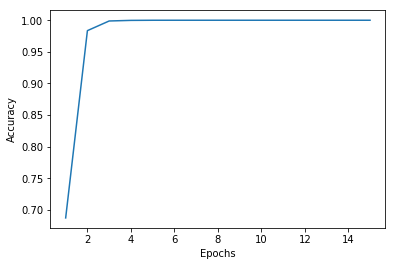

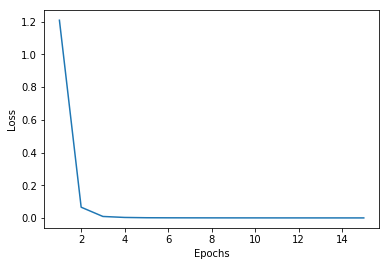

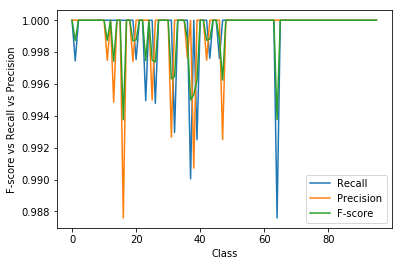

In [16]:
plot(1,epochs+1,history.acc,'Accuracy')
plot(1,epochs+1,history.loss,'Loss')
plt.plot(recall,label='Recall')
plt.plot(prec,label='Precision')
plt.xlabel('Class')
plt.ylabel('F-score vs Recall vs Precision')
plt.plot(fscore,label='F-score')
plt.legend()

In [17]:
avg_fscore=np.mean(fscore)
print(avg_fscore)
avg_precision=np.mean(prec)
print(avg_precision)
avg_recall=np.mean(recall)
print(avg_recall)
cnf_mat = confusion_matrix(np.argmax(y_test,axis=1), y_pred)

0.9994061564164128
0.9994102664119064
0.999406555434286


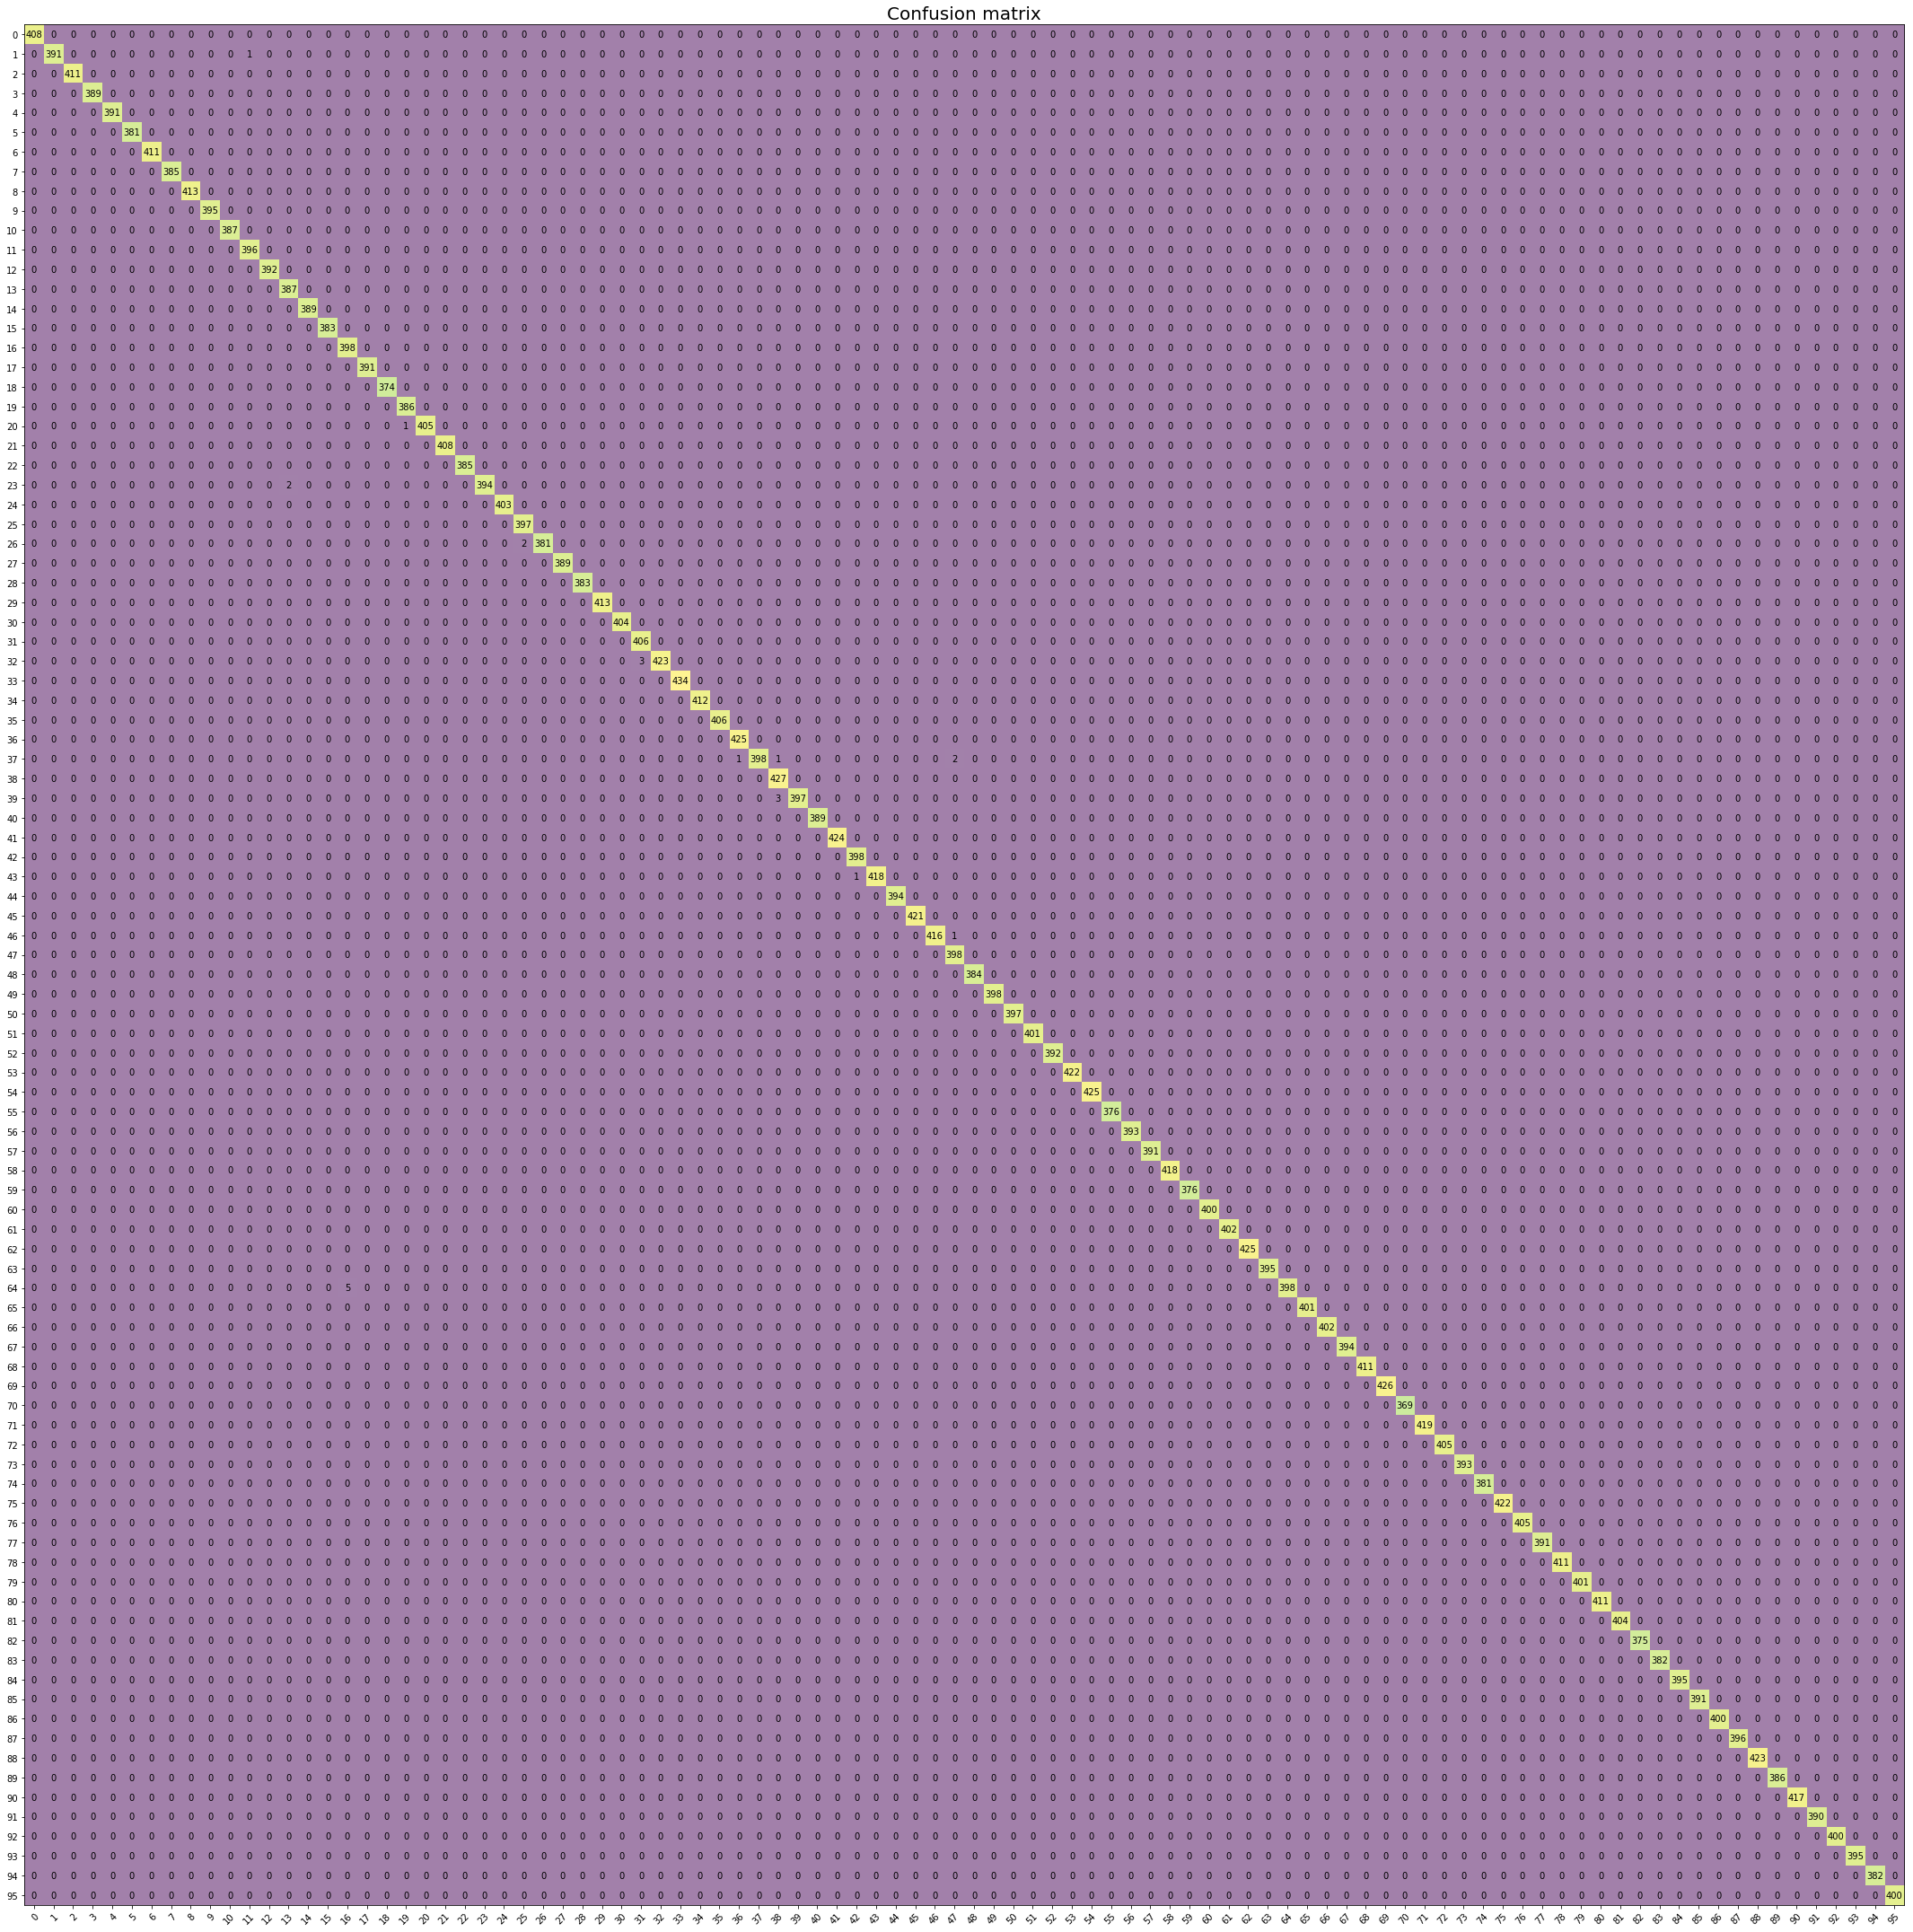

In [18]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


conf = cnf_mat


fig, ax = plt.subplots(figsize=(30,30))
im = ax.imshow(conf,alpha=0.5)
# plt.show()

# We want to show all ticks...
ax.set_xticks(np.arange(cnf_mat.shape[0]))
ax.set_yticks(np.arange(cnf_mat.shape[1]))
# ... and label them with the respective list entries
ax.set_xticklabels(np.arange(0,96))
ax.set_yticklabels(np.arange(0,96))

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(cnf_mat.shape[0]):
    for j in range(cnf_mat.shape[1]):
        text = ax.text(j, i, conf[i, j],
                       ha="center", va="center",color="black",fontsize=10)
ax.set_title("Confusion matrix",fontsize=20)
fig.tight_layout()

# fig.savefig('plot1_cnf.png')
plt.show()

In [19]:
del model